In this notebook we play with different option to visualize the performance of the model. One key plot we used so far is the 95% 2D histogram. In that plot the colorbar is used to indicate the density of the points. 

A problem of such visualization is that it tends to be antintuitive as something that should be ignored (e.g. a larger uncertainty on pixels as rare as 1 in 10mln) appears as the most evident feature of the plot. Also, the color scale applied to the normalized pixel density is not something that a reader can quickly interpret in asbolute terms.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sdo.viz.plot_vt_outputs import plot_2Dhist_95cl
from mpl_toolkits.mplot3d import Axes3D

In [2]:
data_inventory =  '/home/Valentina/inventory_1904.pkl'
results_path = '/home/Valentina/results/'

In [3]:
# For details about how these predictions have been calculated refer to the the notebook 
# flares/experiments/02_train_on_flares.ipynb
pred20_on20 = results_path + '0600_test20_on20_test_predictions.npy'

Y = np.load(pred20_on20)
shape = Y.shape
Y_test = Y[:,:,0:int(shape[2]/2),:]
Y_pred = Y[:,:,int(shape[2]/2):,:]

### 1D histogram

In [4]:
Y_test.shape

(667, 1, 512, 512)

In [5]:
(Y_test.flatten() >= 0).sum(), (Y_pred.flatten() >= 0).sum()

(174850048, 174850048)

In [6]:
len(Y_test.flatten()), len(Y_pred.flatten())

(174850048, 174850048)

No negative pixels (but we have some 0 pixels that will create issues with the log)

In [7]:
# this will take a minute or two
Y_test = Y_test.flatten()
Y_pred = Y_pred.flatten()
idx = np.argsort(Y_test)
Y_test = Y_test[idx]
Y_pred = Y_pred[idx]

In [8]:
mask1 = Y_test > 0
Y_test = Y_test[mask1]
Y_pred = Y_pred[mask1]

In [9]:
Y_test[0], Y_pred[0]

(2.2955583e-05, 0.0038874464)

In [10]:
max(Y_test), max(Y_pred)

(25.480843, 66.11577)

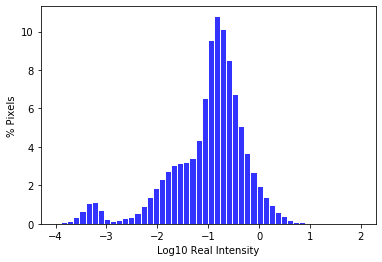

In [11]:
bins = 50
xrange = [-4,2]
width = 0.1
y, binEdges = np.histogram(np.log10(Y_test), bins=bins, range=xrange)
ynorm = y/len(Y_test)*100
bincenters = 0.5*(binEdges[1:] + binEdges[:-1])
plt.bar(bincenters, ynorm, width=width, color='b', alpha=0.8)
plt.xlabel('Log10 Real Intensity')
plt.ylabel('% Pixels')
plt.show()

In [12]:
binEdges[1]

-3.88

In [13]:
# this will take a few minutes
i = 0
l_bins= []
l_bincenters = []
for val in Y_test:
    if np.log10(val) <= binEdges[i+1]:
        l_bins.append(i)
    else:
        i=i+1
        l_bins.append(i)
    l_bincenters.append(bincenters[i])

In [14]:
df = pd.DataFrame({'Bins':l_bins, 'BinCenters':l_bincenters, 'YTest':Y_test,'YPred':Y_pred})
df['YTest-YPred'] = df.YTest - df.YPred
df['log10_YTest-log10_YPred'] = np.log10(df.YTest) - np.log10(df.YPred)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df['(YTest-YPred)/YTest'] = (df.YTest - df.YPred)/df.YTest*100

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
df.head(5)

,Bins,BinCenters,YTest,YPred,YTest-YPred,log10_YTest-log10_YPred,(YTest-YPred)/YTest
0,0,-3.94,0.000023,0.003887,-0.003864,-2.228776,-16834.644531
2,0,-3.94,0.000023,0.000689,-0.000666,-1.477039,-2899.434570
3,0,-3.94,0.000023,0.002820,-0.002797,-2.089332,-12183.784180
7,0,-3.94,0.000023,0.002596,-0.002573,-2.053378,-11207.790039
8,0,-3.94,0.000023,0.001416,-0.001393,-1.790024,-6066.288574


### Boxplot

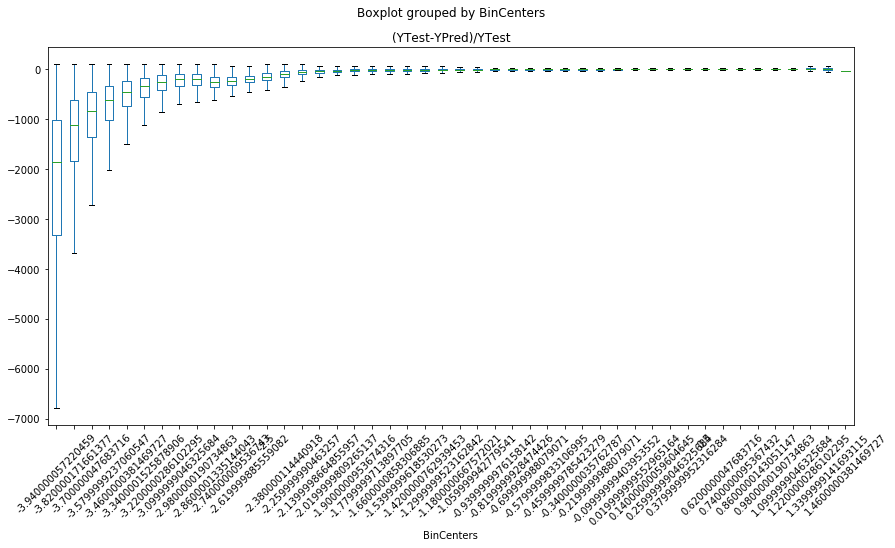

In [16]:
df.boxplot('(YTest-YPred)/YTest', by='BinCenters', showfliers=False, grid=False, rot=45, figsize=(14, 7))

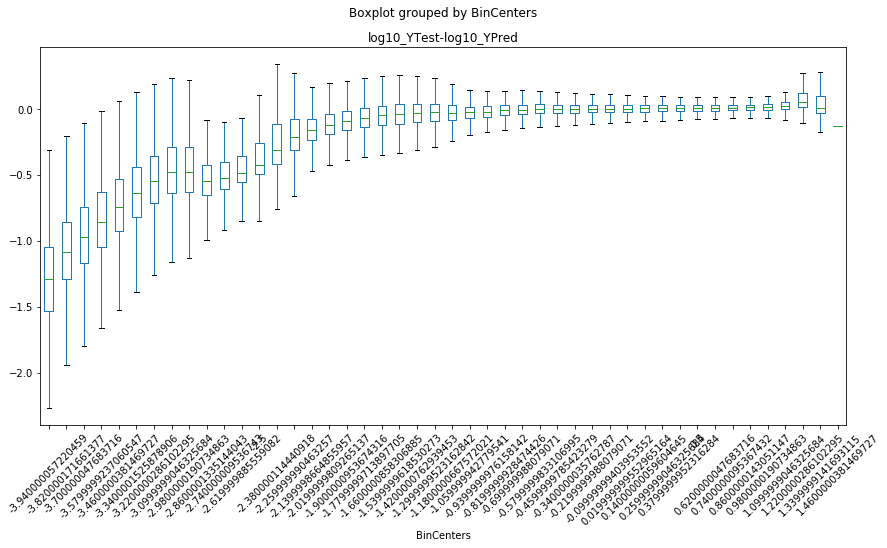

In [17]:
df.boxplot('log10_YTest-log10_YPred', by='BinCenters', showfliers=False, grid=False, rot=45, figsize=(14, 7))

the X axis retuned by boxplot for some reason is not interpreted as float, this means it can't be used to share X axis with the histogram, couldn't find a way to change this

### Merging plots together

In [69]:
df_q = df[['BinCenters','log10_YTest-log10_YPred']].sample(frac=0.2).groupby('BinCenters').quantile([0.05, 0.5, 0.95]).unstack()
df_q = df_q.reset_index()
df_q[:10]

In [88]:
df_q['log10_YTest-log10_YPred'][0.95][:10], df_q['log10_YTest-log10_YPred'][0.5][:10]

(0   -0.486801
 1   -0.318340
 2   -0.221798
 3   -0.112514
 4   -0.034123
 5    0.038221
 6    0.098957
 7    0.133092
 8    0.097158
 9   -0.134702
 Name: 0.95, dtype: float64, 0   -1.293462
 1   -1.090465
 2   -0.972361
 3   -0.853846
 4   -0.742970
 5   -0.639570
 6   -0.547456
 7   -0.475618
 8   -0.476962
 9   -0.548687
 Name: 0.5, dtype: float64)

<ErrorbarContainer object of 3 artists>

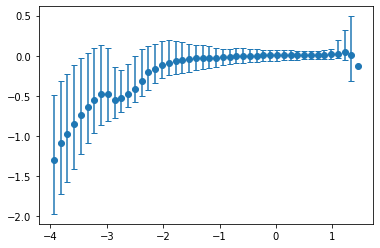

In [102]:
ym = df_q['log10_YTest-log10_YPred'][0.5] - df_q['log10_YTest-log10_YPred'][0.05]
yp = df_q['log10_YTest-log10_YPred'][0.95] - df_q['log10_YTest-log10_YPred'][0.5]
plt.errorbar(df_q['BinCenters'], df_q['log10_YTest-log10_YPred'][0.5], yerr=(ym, yp), fmt='o', capsize=3)

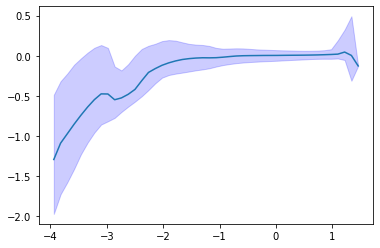

In [105]:
plt.fill_between(df_q['BinCenters'], df_q['log10_YTest-log10_YPred'][0.05], df_q['log10_YTest-log10_YPred'][0.95],
                 color='blue', alpha=0.2)
plt.plot(df_q['BinCenters'], df_q['log10_YTest-log10_YPred'][0.5])

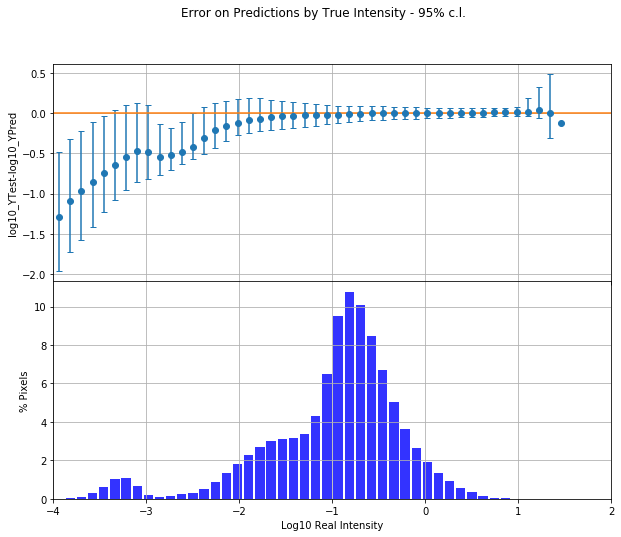

In [118]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10,8))
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('Error on Predictions by True Intensity - 95% c.l.')
ax1.errorbar(df_q['BinCenters'], df_q['log10_YTest-log10_YPred'][0.5], yerr=(ym, yp), fmt='o', capsize=3)
ax1.plot([-4,2], [0,0])
ax1.set_ylabel('log10_YTest-log10_YPred')
ax2.bar(bincenters, ynorm, width=width, color='b', alpha=0.8)
ax2.set_xlabel('Log10 Real Intensity')
ax2.set_ylabel('% Pixels')
ax2.set_xlim(-4,2)
ax1.grid()
ax2.grid()

### Changing scale to Y axis and remove sampling

In [119]:
df.head()

,Bins,BinCenters,YTest,YPred,YTest-YPred,log10_YTest-log10_YPred,(YTest-YPred)/YTest,LogYTest
0,0,-3.94,0.000023,0.003887,-0.003864,-2.228776,-16834.644531,-4.639112
2,0,-3.94,0.000023,0.000689,-0.000666,-1.477039,-2899.434570,-4.639112
3,0,-3.94,0.000023,0.002820,-0.002797,-2.089332,-12183.784180,-4.639111
7,0,-3.94,0.000023,0.002596,-0.002573,-2.053378,-11207.790039,-4.639111
8,0,-3.94,0.000023,0.001416,-0.001393,-1.790024,-6066.288574,-4.639111


In [177]:
df_q2 = df[['BinCenters','YTest', 'YTest-YPred']].groupby('BinCenters').quantile([0.05, 0.5, 0.95]).unstack()
df_q2 = df_q2.reset_index()
df_q2[:10]

BinCenters     YTest                     YTest-YPred                    
                  0.05       0.5      0.95        0.05       0.5      0.95
0      -3.94  0.000046  0.000100  0.000129   -0.008476 -0.001784 -0.000204
1      -3.82  0.000136  0.000156  0.000172   -0.008213 -0.001739 -0.000164
2      -3.70  0.000178  0.000206  0.000227   -0.007897 -0.001698 -0.000132
3      -3.58  0.000234  0.000271  0.000299   -0.007086 -0.001653 -0.000082
4      -3.46  0.000308  0.000355  0.000394   -0.005415 -0.001602 -0.000028
5      -3.34  0.000405  0.000463  0.000518   -0.005034 -0.001550  0.000040
6      -3.22  0.000532  0.000599  0.000681   -0.004782 -0.001517  0.000121
7      -3.10  0.000699  0.000772  0.000892   -0.004775 -0.001544  0.000206
8      -2.98  0.000919  0.001005  0.001173   -0.005753 -0.002031  0.000209
9      -2.86  0.001218  0.001386  0.001566   -0.006878 -0.003502 -0.000486

NB. We can't take log10(Ytest-YPred) because for small intensity these values are negative. 
We could take the log of the abs but it would became difficult to include the errors

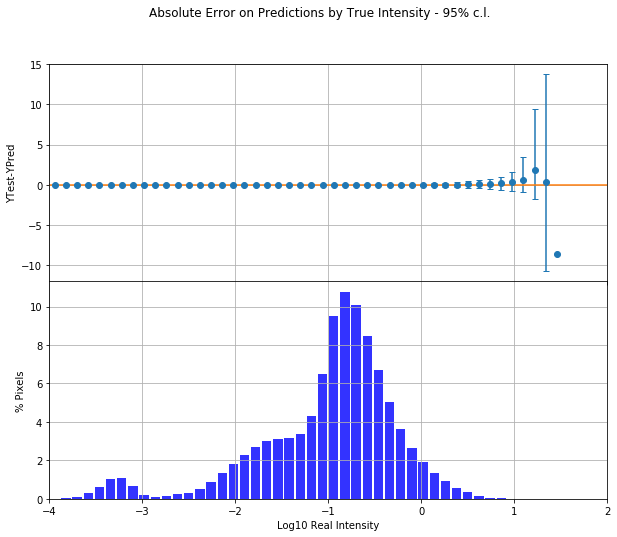

In [178]:
ym = df_q2['YTest-YPred'][0.5] - df_q2['YTest-YPred'][0.05]
yp = df_q2['YTest-YPred'][0.95] - df_q2['YTest-YPred'][0.5]
logym = np.log10(ym)
logyp = np.log10(yp)
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10,8))
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('Absolute Error on Predictions by True Intensity - 95% c.l.')
ax1.errorbar(df_q2['BinCenters'], 
             df_q2['YTest-YPred'][0.5], yerr=(ym, yp), fmt='o', capsize=3)
ax1.plot([-4,2], [0,0])
ax1.set_ylabel('YTest-YPred')
ax2.bar(bincenters, ynorm, width=width, color='b', alpha=0.8)
ax2.set_xlabel('Log10 Real Intensity')
ax2.set_ylabel('% Pixels')
ax2.set_xlim(-4,2)
ax1.grid()
ax2.grid()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


<ErrorbarContainer object of 3 artists>

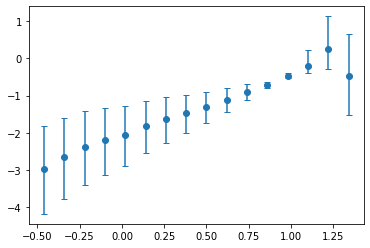

In [179]:
plt.errorbar(x=df_q2['BinCenters'], 
             y=np.log10(df_q2['YTest-YPred'][0.5]), yerr=(logym, logyp), fmt='o', capsize=3)

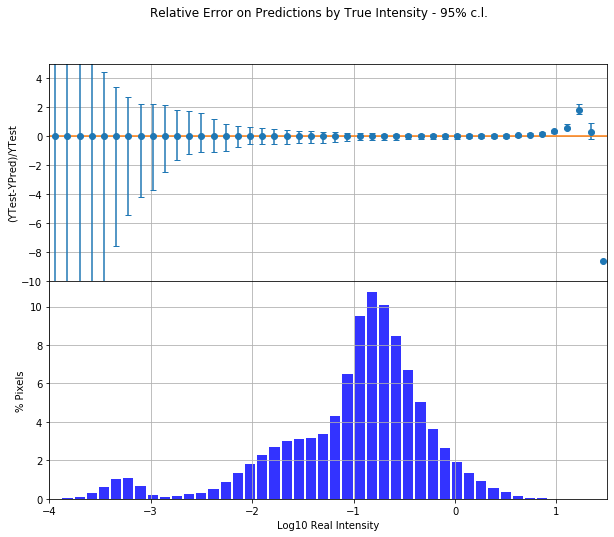

In [185]:
Y_percent =  df_q2['YTest-YPred'][0.5]/df_q2['YTest'][0.5]
ym = (df_q2['YTest-YPred'][0.5] - df_q2['YTest-YPred'][0.05])/df_q2['YTest'][0.5]
yp = (df_q2['YTest-YPred'][0.95] - df_q2['YTest-YPred'][0.5])/df_q2['YTest'][0.5]
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10,8))
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('Relative Error on Predictions by True Intensity - 95% c.l.')
ax1.errorbar(df_q2['BinCenters'], 
             df_q2['YTest-YPred'][0.5], yerr=(ym, yp), fmt='o', capsize=3)
ax1.plot([-10,5], [0,0])
ax1.set_ylim(-10,5)
ax1.set_ylabel('(YTest-YPred)/YTest')
ax2.bar(bincenters, ynorm, width=width, color='b', alpha=0.8)
ax2.set_xlabel('Log10 Real Intensity')
ax2.set_ylabel('% Pixels')
ax2.set_xlim(-4,1.5)
ax1.grid()
ax2.grid()